In [14]:
%conda install -c anaconda libev
%conda install -c msys2 m2-make
%conda install -c conda-forge pkg-config
%pip install cassandra-driver
%pip install psycopg2

Channels:
 - anaconda
 - defaults
Platform: win-64
Solving environment: failed

Note: you may need to restart the kernel to use updated packages.



PackagesNotFoundError: The following packages are not available from current channels:

  - libev

Current channels:

  - https://conda.anaconda.org/anaconda
  - defaults

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




Channels:
 - msys2
 - defaults
Platform: win-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c defaults conda




Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c defaults conda




Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import random
import uuid
import psycopg2
import time
from datetime import datetime, timedelta
from cassandra.cluster import Cluster

cluster = Cluster(['localhost'])
cassandra = cluster.connect('my_keyspace')

connect = psycopg2.connect(dbname="lab15", user="postgres", password="postgres", host="localhost", port=5432)
connect.autocommit = True
postgres = connect.cursor()

def random_date(start, end):
    return start + timedelta(
        seconds=random.randint(0, int((end - start).total_seconds()))
    )

def create() -> None:
    cassandra_query = """
    create table if not exists temperature_day (
        sensor_id text,
        date text,
        event_time timestamp,
        temperature float,
        primary key((sensor_id, date), event_time)
    ) with clustering order by (event_time asc)
    """
    postgres_query = """
    create table if not exists temperature_day (
        sensor_id text,
        date text,
        event_time timestamp,
        temperature float,
        primary key(sensor_id, date, event_time)
    )
    """
    cassandra.execute(cassandra_query)
    postgres.execute(postgres_query)
    print("Tabla temperature_day creada correctamente.")

def drop() -> None:
    query = "drop table if exists temperature_day"
    cassandra.execute(query)
    postgres.execute(query)
    print("Tabla temperature_day eliminada correctamente.")

def insert():
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2024, 1, 1)
    some_id = None
    some_date = None

    n = 10000

    for _ in range(n):
        sensor_id = str(uuid.uuid4())
        date = random_date(start_date, end_date).strftime('%Y-%m-%d')
        event_time = random_date(start_date, end_date)
        temperature = random.uniform(-30.0, 50.0)

        if _ == n//2:
            some_id = sensor_id
            some_date = date

        query = """
        insert into temperature_day(sensor_id, date, event_time, temperature)
        values (%s, %s, %s, %s)
        """

        cassandra.execute(query, (sensor_id, date, event_time, temperature))
        postgres.execute(query, (sensor_id, date, event_time, temperature))

    print(f"{n} filas insertadas correctamente en la tabla temperature_day.")
    return some_id, some_date

def test(sensor_id, date) -> None:
    query = """
    select *
    from temperature_day
    where sensor_id = '{sensor_id}' and date = '{date}'
    """
    start = time.time()
    cassandra_result = cassandra.execute(query)
    end = time.time()
    cassandra_time = end - start

    start = None
    end = None

    start = time.time()
    postgres.execute(query)
    postgres_result = postgres.fetchall()
    end = time.time()
    postgres_time = end - start
    print(f"Tiempo de ejecución en Cassandra: {cassandra_time:.4f} segundos")
    print(f"Tiempo de ejecución en PostgreSQL: {postgres_time:.4f} segundos")

drop()
create()
some_id, some_date = insert()
test(some_id, some_date)

Tabla temperature_day eliminada correctamente.
Tabla temperature_day creada correctamente.
10000 filas insertadas correctamente en la tabla temperature_day.
Tiempo de ejecución en Cassandra: 0.0138 segundos
Tiempo de ejecución en PostgreSQL: 0.0010 segundos


Prueba en DataGrip, se uso el mismo tipo de query pero con valores distintos de id y date.

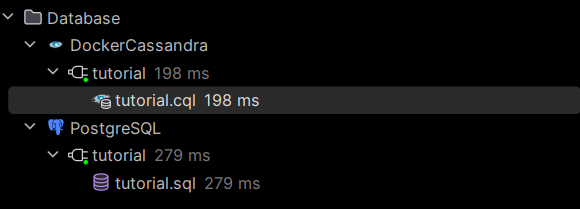